# Introduction
This is a project that take the "BBC News Classification" data set from Kaggle, and attempts to classify matrix factorization, which is a form of unsupervised learning. I also perform supervised learning methods on the data, and compare the results to the unsupervised methods. 

Link to Jupyter notebook: https://github.com/highdeltav/Unsupervised-Learning-Week3

In [1]:
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import NMF
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import ConfusionMatrixDisplay 
from sklearn.decomposition import non_negative_factorization
from itertools import permutations

#This is just for formatting, since some of the Sklearn permutations had warnings
import warnings 
warnings.filterwarnings("ignore")

np.set_printoptions(suppress=True)

In [2]:
file_train = 'bbc_data/BBC News Train.csv'
file_test  = 'bbc_data/BBC News Test.csv'
df_train   = pd.read_csv(file_train)
df_test    = pd.read_csv(file_test)


X_train = df_train['Text']
y_train = df_train['Category']
X_test = df_test['Text']

X_train = X_train.replace(',','', regex=True)
X_test = X_test.replace(',','', regex=True)

#Created for the text database, so the train and test sets can be run against the same model
X_all = pd.concat([X_train, X_test])


In [3]:
df_train

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business
...,...,...,...
1485,857,double eviction from big brother model caprice...,entertainment
1486,325,dj double act revamp chart show dj duo jk and ...,entertainment
1487,1590,weak dollar hits reuters revenues at media gro...,business
1488,1587,apple ipod family expands market apple has exp...,tech


# Cleaning and EDA

This started off as a clean data set. I did want to make sure that before it was uploaded to Kaggle that everything was made lower-case, and that punctuation had been removed. I also checked to make sure that there were no null values that were a part of the text. 

In [4]:
#Verify everything is lower Case
print(X_train.head())
X_train = X_train.str.lower()
print(f"Number of Null Values: {X_train.isna().sum()}")


0    worldcom ex-boss launches defence lawyers defe...
1    german business confidence slides german busin...
2    bbc poll indicates economic gloom citizens in ...
3    lifestyle  governs mobile choice  faster  bett...
4    enron bosses in $168m payout eighteen former e...
Name: Text, dtype: object
Number of Null Values: 0


## Text to Matrix Conversion
### TF-IDF
I decided to use Term Frequency-Inverse Document Frequency for converting words into matrices. At first glance, it appears simple to just take the number of occurrences of each word, divide by the total words in the documents, and create a matrix of that information. That is called term frequency. However, doing that will create a model that will assign greater importance to common, and unimportant words.  TF-IDF tries to rectify this by creating weights for each word. It decreases the weights of common words, and increases the weights of less common words. It does this by combining term frequency with document frequency. Document frequency is the number of documents that contain that specific term. 

To be more sepcific, the formula that is used is $tf(t,d)*log\frac{N}{df+1}$. where DF is the document frequency, and N is the document set. $tf(t,)d$ is the term frequency for document D. The plus one is added to prevent dividing by 0, and the log is taken to reduce the effect of a large N.

### Process
The first thing I did was convert the data sets to TF-IDF for both the training and test sets. I also made a third set that combines the documents from both train and test. This third set could be used to get information on the data such as, which words are the most common. As a part of the process, I did use a list of stop words that were eliminated from the text completely. These words are some of the most common words, that would be found in every document. By eliminating them, it eliminates noise from the model.

In [5]:
# Create the matrix with TFI
tfi = TfidfVectorizer(stop_words = 'english')
tfi.fit(X_all)
X_tfi_all = tfi.transform(X_all)
X_tfi_train = tfi.transform(X_train)
X_tfi_test =  tfi.transform(X_test)

#Create the matrix with word counts
cv = CountVectorizer(stop_words = 'english')
cv.fit(X_all)
X_cv_all = cv.fit_transform(X_all)
X_cv_train = cv.transform(X_train)
X_cv_test = cv.transform(X_test)




Once I had the words converted to matrix form, I created some histograms. The first histogram showed that most words only occurred a few times, but it was hard to see how many outliers there were. These words would be much more common words. To how many of those there were, I then limited the y-axis to 10, so I could see the rest of the histogram better. It showed that there were some words that occurred much more often. One word (‘said’) occurred 7255 times. These are the words that we wanted to limit the weight of in our final model.

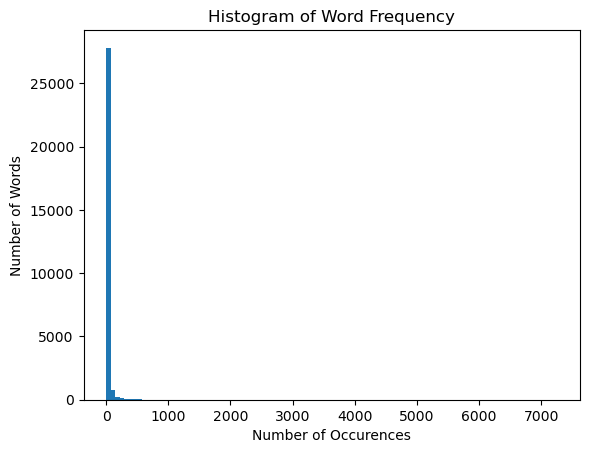

In [6]:
plt.hist(np.sum(X_cv_all.toarray(), axis = 0), bins = 100)
plt.xlabel('Number of Occurences')
plt.ylabel('Number of Words')
plt.title('Histogram of Word Frequency')
plt.show()

(0.0, 10.0)

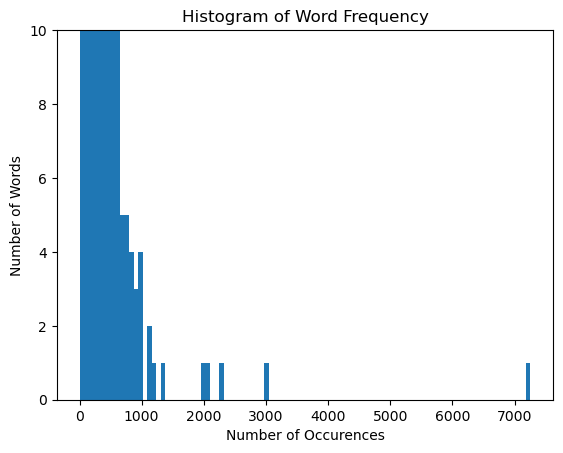

In [7]:

plt.hist(np.sum(X_cv_all.toarray(), axis = 0), bins = 100)
plt.xlabel('Number of Occurences')
plt.ylabel('Number of Words')
plt.title('Histogram of Word Frequency')
plt.ylim([0,10])


In [8]:
#Find the most common word
words_index_sorted = np.sum(X_cv_all.toarray(), axis = 0).argsort()[::-1]

print('Most common words:')
for i in range(0,10):
    print(f"{i+1}. {cv.get_feature_names_out()[words_index_sorted[i]]}: {np.sum(X_cv_all.toarray(), axis = 0)[words_index_sorted[i]]}")

Most common words:
1. said: 7255
2. mr: 3005
3. year: 2309
4. people: 2045
5. new: 1978
6. time: 1322
7. world: 1201
8. government: 1160
9. uk: 1115
10. years: 1003


# Model

For the model, I chose to use the Non-negative Matrix Factorization method. This model works well with text manipulation. The problem we were given was a classification problem. This is a somewhat unique way of using NMF, since NMF is unsupervised learning. Since we did have labels for the data, we could check the accuracy of the model. Because we were attempting to check the accuracy of classification with 5 categories of text, I limited the final model to 5 components. This allowed me to categorize each document into each in a category by taking the using the feature with the maximum weight. 

While I primarily did this modeling with TF-IDF, I also created a model just based on the count of the words. I did this to see how much more accurate TF-IDF is, than just using the word counts per document. 

After I did the modeling, I would upload a CSV to Kaggle to get the test accuracy. That is where the 'test' accuracy values come from. 

In [9]:
"""
Function for performing the modeling
"""

def classify(NMF_array):
    """
    Return a prediction where it takes the most likely category and assignes them a number
    from that category. 
    """
    return np.argmax(NMF_array, axis = 1)

def label_permute_compare(ytdf,yp,n=5):
    """
    Returns accuracy and the best permutation of the predictions
    """
    
    #Extract information from the dataframes and prediction output
    label_perm = list(permutations(pd.unique(ytdf)))
    #label_values = ytdf.value_counts()
    #print(label_values)
    #print(label_perm)
    max_acc = 0
    best_perm = []
    
    for perm in label_perm:
        temp_acc = compute_accuracy(ytdf, yp, perm)
        if temp_acc > max_acc:
            max_acc = temp_acc
            best_perm = perm
    return (tuple(best_perm), max_acc)

def compute_accuracy(ytdf, yp, cluster_order = None):
    """
    Retursn the accuracy of of a prediction.
    Optionally takes a different order for the values. Useful when permutating.
    """
    
    yp_rename = yp.astype(object)
    #Organize the order if needed
    if cluster_order != None:
        yp_rename = convert_to_labels(yp, cluster_order)
    
    accuracy = (np.count_nonzero(yp_rename == ytdf))/len(yp_rename)
    return accuracy

def convert_to_labels(yp, cluster_order):
    """
    Converts numbers to a cluster catagories, or rearranges catagorical clusters
    """
    yp_rename = yp.astype(object)
    for k in range(0,len(cluster_order)):
        #Rename the clusters to the correct label
        yp_rename[yp_rename == k] = cluster_order[k]
    return(yp_rename)

def export_for_kaggle(filename, predictions): 
    """
    Takes the prections, and creates a CSV file that meets the requirements for Kaggle
    """
    df_test_pred = df_test
    df_test_pred['Category'] = predictions
    pd.DataFrame(df_test_pred).to_csv(filename, index = False, columns = ['ArticleId','Category' ])

## NMF

In [10]:
NMF_model = NMF(n_components = 5, init = 'nndsvda')
NMF_model.fit(X_tfi_train)
NMF_transform_train = NMF_model.transform(X_tfi_train)
NMF_transform_test = NMF_model.transform(X_tfi_test)

In [11]:
y_pred_train = classify(NMF_transform_train)
y_pred_test = classify(NMF_transform_test)
#pd.DataFrame(y_pred_test, columns = 'prediction')

In [12]:
labels, accuracy = label_permute_compare(y_train, y_pred_train)
print(f"Train: Accuracy: {accuracy}, Labels: {labels}")


Train: Accuracy: 0.9167785234899329, Labels: ('sport', 'politics', 'tech', 'entertainment', 'business')


In [13]:
print(NMF_model.components_.shape)
print(X_tfi_train.shape)
print(NMF_transform_train.shape)

(5, 29126)
(1490, 29126)
(1490, 5)


In [14]:
y_pred_with_labels = convert_to_labels(y_pred_test, labels)

In [15]:
export_for_kaggle('start_nmf_train.csv', y_pred_with_labels)

In [16]:
print(f"Train: Accuracy: {accuracy:.5f}")
print("Test: Accuracy .92244")

Train: Accuracy: 0.91678
Test: Accuracy .92244


## Tune hyperparameters
### TF- IDF
After using the default values, and finding decent accuracy, I then tuned the hyperparameters, in an attempt to find parameters that would give me a more accurate answer. I did this for both the TF-IDF and the count vector matrices.  

In [17]:
solver = ['cd','mu']
beta_loss = ['frobenius', 'kullback-leibler']
init = ['random', 'nndsvd', 'nndsvda', 'nndsvdar']

accuracy_list = []
parameter_list = []

for i in solver:
        for j in beta_loss:
            for k in init:
                try:
                    NMF_model_multi = NMF(n_components = 5, 
                                          solver = i, 
                                          beta_loss = j, 
                                          random_state = 213,
                                          init = k )
                    NMF_model_multi.fit(X_tfi_train)
                    NMF_transform_train_multi = NMF_model_multi.transform(X_tfi_train)

                    y_pred_train_multi = classify(NMF_transform_train_multi)
                    labels_multi, accuracy_multi = label_permute_compare(y_train, y_pred_train_multi)
                    #print(NMF_model_multi.get_params())
                    #print(f"Train: Accuracy: {accuracy_multi}")
                    accuracy_list.append(accuracy_multi)
                    parameter_list.append([i,j,k])
                except:
                    continue
                
#NMF_transform_test = NMF_model.transform(X_tfi_test)

## Count Vector

In [18]:
solver = ['cd','mu']
beta_loss = ['frobenius', 'kullback-leibler']
init = ['random', 'nndsvd', 'nndsvda', 'nndsvdar']

accuracy_list_cv = []
parameter_list_cv = []

for i in solver:
        for j in beta_loss:
            for k in init:
                try:
                    NMF_model_multi = NMF(n_components = 5, 
                                          solver = i, 
                                          beta_loss = j, 
                                          random_state = 213, 
                                          init = k )
                    NMF_model_multi.fit(X_cv_train)
                    NMF_transform_train_multi = NMF_model_multi.transform(X_cv_train)

                    y_pred_train_multi = classify(NMF_transform_train_multi)
                    labels_multi, accuracy_multi = label_permute_compare(y_train, y_pred_train_multi)
                    #print(NMF_model_multi.get_params())
                    #print(f"Train: Accuracy: {accuracy_multi}")
                    accuracy_list_cv.append(accuracy_multi)
                    parameter_list_cv.append([i,j,k])
                except:
                    # Ignore parameters that don't work together
                    continue
                

### Comparison CV and TF-IDF

As expected, there was a huge difference between just counting the different words in each article, and using TF-IDF. The absolute best accuracy for CV was only 80 percent, for the training data, with around 93 percent for the training data with TF-IDF.

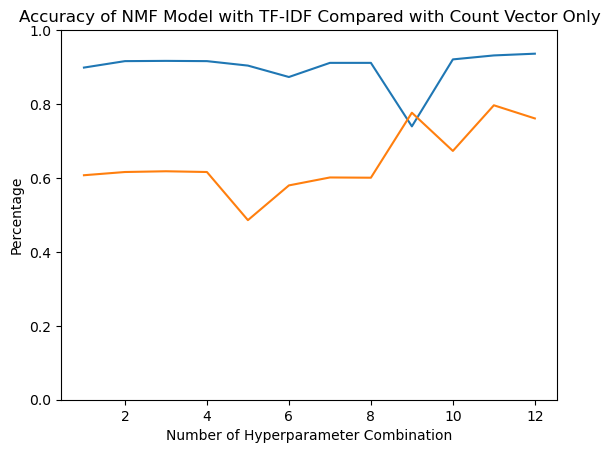

TF-IDF
1. 0.8987: ['cd', 'frobenius', 'random'] 
2. 0.9161: ['cd', 'frobenius', 'nndsvd'] 
3. 0.9168: ['cd', 'frobenius', 'nndsvda'] 
4. 0.9161: ['cd', 'frobenius', 'nndsvdar'] 
5. 0.9040: ['mu', 'frobenius', 'random'] 
6. 0.8732: ['mu', 'frobenius', 'nndsvd'] 
7. 0.9114: ['mu', 'frobenius', 'nndsvda'] 
8. 0.9114: ['mu', 'frobenius', 'nndsvdar'] 
9. 0.7396: ['mu', 'kullback-leibler', 'random'] 
10. 0.9208: ['mu', 'kullback-leibler', 'nndsvd'] 
11. 0.9315: ['mu', 'kullback-leibler', 'nndsvda'] 
12. 0.9362: ['mu', 'kullback-leibler', 'nndsvdar'] 


CF
1. 0.6074: ['cd', 'frobenius', 'random'] 
2. 0.6161: ['cd', 'frobenius', 'nndsvd'] 
3. 0.6181: ['cd', 'frobenius', 'nndsvda'] 
4. 0.6161: ['cd', 'frobenius', 'nndsvdar'] 
5. 0.4859: ['mu', 'frobenius', 'random'] 
6. 0.5799: ['mu', 'frobenius', 'nndsvd'] 
7. 0.6013: ['mu', 'frobenius', 'nndsvda'] 
8. 0.6007: ['mu', 'frobenius', 'nndsvdar'] 
9. 0.7765: ['mu', 'kullback-leibler', 'random'] 
10. 0.6732: ['mu', 'kullback-leibler', 'nndsvd'] 
11.

In [19]:
x_for_plot = [1,2,3,4,5,6,7,8,9,10,11,12]
plt.plot(x_for_plot,accuracy_list)
plt.plot(x_for_plot,accuracy_list_cv)
plt.title('Accuracy of NMF Model with TF-IDF Compared with Count Vector Only')
plt.xlabel('Number of Hyperparameter Combination')
plt.ylabel('Percentage')
plt.ylim([0,1])
plt.show()

print("TF-IDF")
for i in range(0,len(accuracy_list)):
    print(f"{i+1}. {accuracy_list[i]:.4f}: {parameter_list[i]} ")
print("\n")
print("CF")
for i in range(0,len(accuracy_list_cv)):
    print(f"{i+1}. {accuracy_list_cv[i]:.4f}: {parameter_list_cv[i]} ")

### Best fit model
Once I had the best parameters for the model, which were:
Solver:'mu'
beta_loss: 'kullback-leibler'
Initiate method: 'nndsvdar'

For the best fit model, I uploaded its prediction figures to Kaggle to get its accuracy. I also plotted a confusion matrix for the train data, to better understand where the model was struggling. It seems to struggle the most with differentiation "tech" and "business." From a intuitive level, this makes sense as there is lots of overlap between tech and business. The test data actually had slightly better accuracy, than the training data. 

In [20]:
# Create a model with the best fit for the NMF Model
NMF_model_best = NMF(n_components = 5,
                     solver = 'mu', 
                     beta_loss = 'kullback-leibler', 
                     random_state = 213,
                     init = 'nndsvdar' )
NMF_model_best.fit(X_tfi_train)
NMF_transform_train_best = NMF_model_best.transform(X_tfi_train)
NMF_transform_test_best = NMF_model_best.transform(X_tfi_test)
y_pred_train_best = classify(NMF_transform_train_best)
y_pred_test_best = classify(NMF_transform_test_best)

labels, accuracy = label_permute_compare(y_train, y_pred_train_best)

# Change the numbers to the text labels
y_pred_best_with_labels_train = convert_to_labels(y_pred_train_best, labels)
y_pred_best_with_labels_test = convert_to_labels(y_pred_test_best, labels)


export_for_kaggle('best_NMF_train1.csv', y_pred_best_with_labels_test)

print(f"Train: Accuracy: {accuracy:.5f}")
print(f"Test: Accuracy: .95238")

Train: Accuracy: 0.93624
Test: Accuracy: .95238


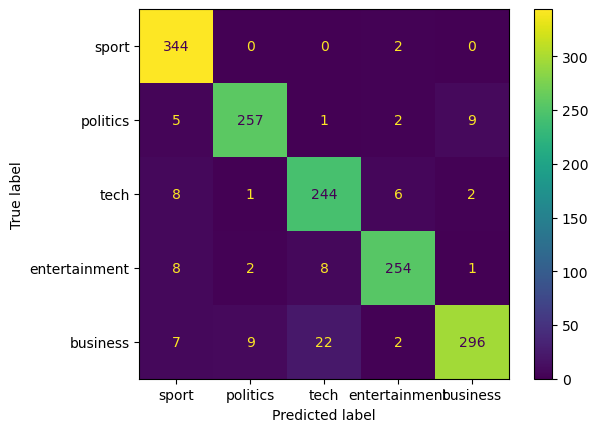

In [21]:
# Create Confusion Matrix
cm_matrix = confusion_matrix(np.array(y_train), y_pred_best_with_labels_train, labels = labels)
disp = ConfusionMatrixDisplay(cm_matrix, display_labels = labels)
disp.plot(values_format='')

## Improvment


One way in which I attempted to improve the model, besides tuning hyperparameters, was to use all of the data set, not just the test data. Normally, with a classification problem, this would not make sense, and would be a poor idea. In this case I decided to try it, because it also increases the number of words included in the model. A model like this does not work well, if it can't use all of the words in the document. In an unsupervised modeling situation, you wouldn't normally split your train and test data, because you have nothing to compare it to, to check for accuracy. Interestingly, the model improved the prediction for the train set, but it stayed the same for the test set. 

There are other ways we could attempt improvement. One way would be to change how we convert the text to a matrix. It would be interesting to compare some other methods to TF-IDF.

In [22]:
# Create a model with the best fit for the NMF Model
NMF_model_best_all = NMF(n_components = 5,
                     solver = 'mu', 
                     beta_loss = 'kullback-leibler', 
                     random_state = 213,
                     init = 'nndsvdar' )
NMF_model_best_all.fit(X_tfi_all)
NMF_transform_train_best_all = NMF_model_best_all.transform(X_tfi_train)
NMF_transform_test_best_all = NMF_model_best_all.transform(X_tfi_test)
y_pred_train_best_all = classify(NMF_transform_train_best_all)
y_pred_test_best_all = classify(NMF_transform_test_best_all)

labels, accuracy = label_permute_compare(y_train, y_pred_train_best_all)

# Change the numbers to the text labels
y_pred_best_with_labels_train_all = convert_to_labels(y_pred_train_best_all, labels)
y_pred_best_with_labels_test_all = convert_to_labels(y_pred_test_best_all, labels)


export_for_kaggle('best_NMF_all.csv', y_pred_best_with_labels_test_all)

print(f"Train: Accuracy: {accuracy}")
print(f"Test: Accuracy: .95238")

Train: Accuracy: 0.9523489932885906
Test: Accuracy: .95238


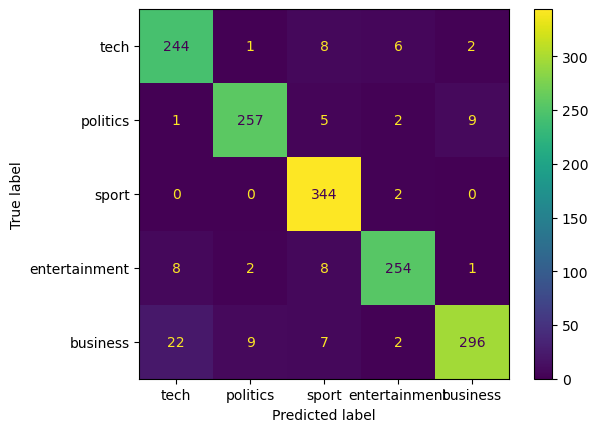

In [23]:
# Create Confusion Matrix
cm_matrix = confusion_matrix(np.array(y_train), y_pred_best_with_labels_train, labels = labels)
disp = ConfusionMatrixDisplay(cm_matrix, display_labels = labels)
disp.plot(values_format='')

# Supervised Learning

For the supervised learning model, I decided to try AdaBoost and KNN. AdaBoost got very poor results, so I didn't continue with that model. However, with KNN, I got values that were similar to what I had with the unsupervised learning. This surprised me a little, because, in general, one wants to use supervised learning when labels are available. I could spend more time fine tuning KNN, or try more supervised learning methods, and I would probably get better results. In fact, there are scores on the Kaggle competition, around .98.) However, it shows that the NMF model is doing a fairly good job in this instance, even when compared to supervised learning.

## AdaBoost

In [24]:
from sklearn.ensemble import AdaBoostClassifier
ada = sklearn.ensemble.AdaBoostClassifier()
ada.fit(X_tfi_train, y_train)


AdaBoostClassifier()

In [25]:
ada_pred_train = ada.predict(X_tfi_train)
ada_pred_test = ada.predict(X_tfi_test)

In [26]:
export_for_kaggle('ada.csv', ada_pred_test)

In [27]:
print('AdaBoost')
print(f"Train: {compute_accuracy(ada_pred_train, np.array(y_train)):.5f}")
print(f"Test: 0.73877")

AdaBoost
Train: 0.77919
Test: 0.73877


## KNN

In [28]:
KNN = KNeighborsClassifier(n_neighbors = 5)
KNN.fit(X_tfi_train, y_train)

KNeighborsClassifier()

In [29]:
knn_pred_train = KNN.predict(X_tfi_train)
knn_pred_test = KNN.predict(X_tfi_test)

In [30]:
compute_accuracy(knn_pred_train, np.array(y_train))

0.9570469798657718

In [31]:

export_for_kaggle('knn.csv', knn_pred_test)

In [32]:
print('KNN')
print(f"Train: {compute_accuracy(knn_pred_train, np.array(y_train)):.5f}")
print(f"Test: 0.92925")

KNN
Train: 0.95705
Test: 0.92925


## Improvement
To improve the efficiency of the KNN model, I changed how much data I trained the model with varying amounts of the train data and compared it to its Kaggle values. 

|Percentage of Train Data|Test Score from Kaggle|
|:----|:--------:|
|.99|.93605 |
|.90|.93469 |
|.80|.93741 |
|.70|.94149 |
|.60|.93061 |
|.50|.91564 |
|.40|.92244 |
|.30|.92108 |
|.20|.92517 |
|.10|.92380 |

There was not a significant difference between using 10 percent and using 50 percent. And then there wasn't a huge difference between 6 percent and 99 percent of the data used for training. That leads me to believe that KNN is efficient for training, and can accomplish a fairly good model, will very little input. 

In [33]:
percents = [.1,.2,.3,.4,.5,.6,.7,.8,.9, .99]

#Loop through splitting up the test data. 
for j in percents:
    # Loop with different data values. It uses .99 to not mess up sklearn
    X_train_small_loop, X_test_small_loop, y_train_small_loop, y_test_small_loop =  train_test_split(X_tfi_train,y_train, train_size = j, random_state = 213)
    KNN_small_loop =  KNeighborsClassifier(n_neighbors = 5)
    KNN_small_loop.fit(X_train_small_loop, y_train_small_loop)
    knn_pred_train_small_loop = KNN_small_loop.predict(X_train_small_loop)
    knn_pred_test_small_loop = KNN_small_loop.predict(X_test_small_loop)
    knn_pred_test_small_loop_kag = KNN_small_loop.predict(X_tfi_test)
    
    # Print the results and export
    print(f"Percent of train data: {j}")
    print(compute_accuracy(knn_pred_train_small_loop, np.array(y_train_small_loop)))
    print(compute_accuracy(knn_pred_test_small_loop, np.array(y_test_small_loop)))
    export_for_kaggle('knn_loop_'+str(j)+'.csv',knn_pred_test_small_loop_kag)

Percent of train data: 0.1
0.9463087248322147
0.9112602535421327
Percent of train data: 0.2
0.9563758389261745
0.9219798657718121
Percent of train data: 0.3
0.9574944071588367
0.925215723873442
Percent of train data: 0.4
0.9563758389261745
0.9205816554809844
Percent of train data: 0.5
0.9583892617449664
0.9140939597315436
Percent of train data: 0.6
0.9552572706935123
0.9194630872483222
Percent of train data: 0.7
0.9568552253116012
0.9194630872483222
Percent of train data: 0.8
0.9538590604026845
0.9228187919463087
Percent of train data: 0.9
0.9537658463832961
0.9395973154362416
Percent of train data: 0.99
0.9572881355932203
0.8666666666666667


# Conclusion
The NMF model did a fairly good job, when modeled with the TF-IDF data for classification. It had similar numbers to the KNN supervised model. While, I am sure a supervised model could be tuned to be better, for an unsupervised model classifying data, the NMF model did well.


# References
BBC News Classification [Data set]. https://www.kaggle.com/competitions/learn-ai-bbc/submissions


Duque, Tiago . (2020, November 9). *How to turn Text into Features.*
  Retrieved from  https://towardsdatascience.com/how-to-turn-text-into-features-478b57632e99

Hamdaoui, Yassine. (2019, December 9). *TF(Term Frequency)-IDF(Inverse Document Frequency) from scratch in python.*   https://towardsdatascience.com/tf-term-frequency-idf-inverse-document-frequency-from-scratch-in-python-6c2b61b78558

Kachkach, Ahmed . (2018, January 10). *Problem-solving with ML: automatic document classification.*
  Retrieved from https://cloud.google.com/blog/products/ai-machine-learning/problem-solving-with-ml-automatic-document-classification

Ramadhan, Luthfi. (2021, January 20). *TF-IDF Simplified.*
  Retrieved from https://towardsdatascience.com/tf-idf-simplified-aba19d5f5530
  

